In [27]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary
from piqa import SSIM
cudnn.benchmark = True
plt.ion()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [28]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [29]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [30]:

train_data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        #transforms.AugMix(),
        transforms.ToTensor(),
    ])


data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,train_data_transforms)
test_dataset = CustomDataset('/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/test/mix',data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

43 11 40


View Data

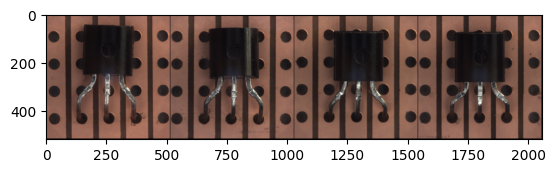

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [32]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [33]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*13*13, 16),#13*13  #29*29
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 256*13*13),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=True),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [34]:
testModel = AutoEncoder()
summary(testModel, (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             392
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,064
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,224
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,832
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,200
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [35]:
torch.manual_seed(0)

## piqa ssim
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

ssimloss = SSIMLoss().to(device)

lr= 0.001
num_epochs = 50

#loss = torch.nn.MSELoss()
loss = torch.nn.L1Loss()
model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
      eta_min= 1e-6/lr)

model.to(device)
torch.set_printoptions(threshold=10_000)

Train

In [36]:
def train_epoch(model, device, dataloader, loss_fn, optimizer,scheduler):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        # # max value 1 ------ ssimloss
        # dd = decoded_data.clone()
        # dd[decoded_data>=1]=1
        # loss = loss_fn(decoded_data, image_batch) + ssimloss(image_batch,dd)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [37]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [38]:
def plot_ae_outputs(model,n=10):
  # inputs = next(iter(val_dataloader))
  # out = torchvision.utils.make_grid(inputs)
  # imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/50 	 train loss 0.18053343892097473 	 val loss 0.1722467541694641


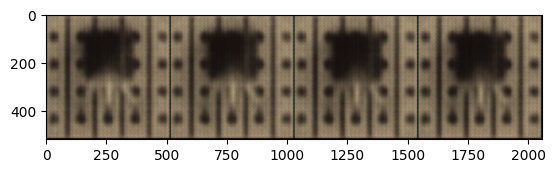


 EPOCH 2/50 	 train loss 0.07995359599590302 	 val loss 0.060904648154973984


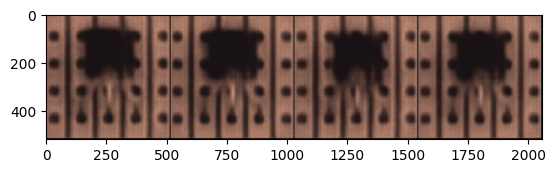


 EPOCH 3/50 	 train loss 0.051802508533000946 	 val loss 0.04770396649837494


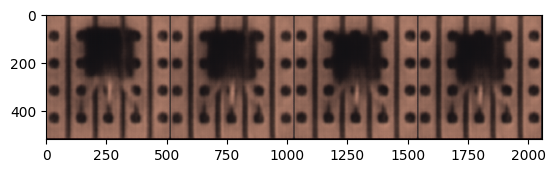


 EPOCH 4/50 	 train loss 0.043243180960416794 	 val loss 0.044062621891498566


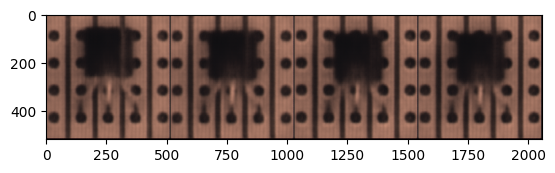


 EPOCH 5/50 	 train loss 0.04061657190322876 	 val loss 0.038266513496637344


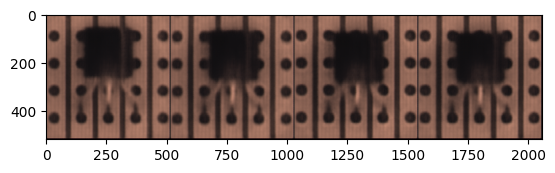


 EPOCH 6/50 	 train loss 0.03790819272398949 	 val loss 0.037014350295066833


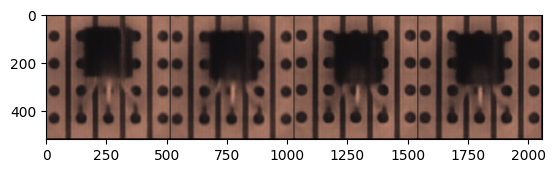


 EPOCH 7/50 	 train loss 0.03602432832121849 	 val loss 0.03563488647341728


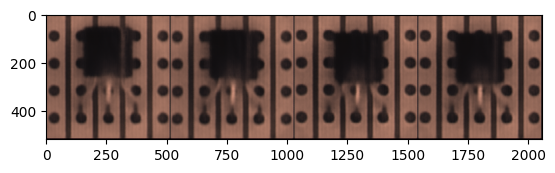


 EPOCH 8/50 	 train loss 0.035263825207948685 	 val loss 0.03596949577331543


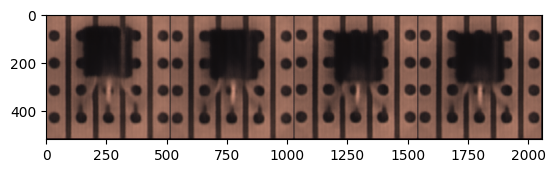


 EPOCH 9/50 	 train loss 0.035055406391620636 	 val loss 0.035242848098278046


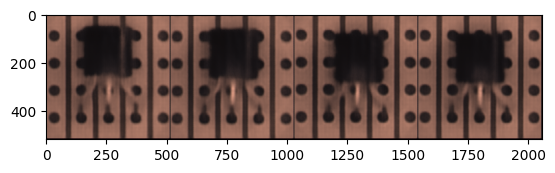


 EPOCH 10/50 	 train loss 0.03276463598012924 	 val loss 0.03503568097949028


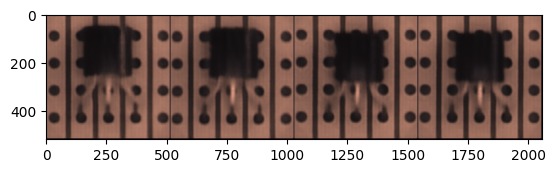


 EPOCH 11/50 	 train loss 0.0320015475153923 	 val loss 0.033835429698228836


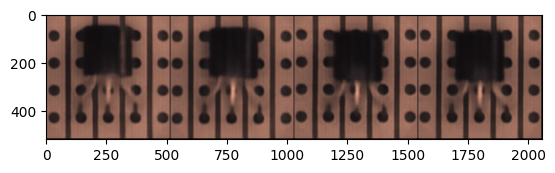


 EPOCH 12/50 	 train loss 0.03173505887389183 	 val loss 0.03278954327106476


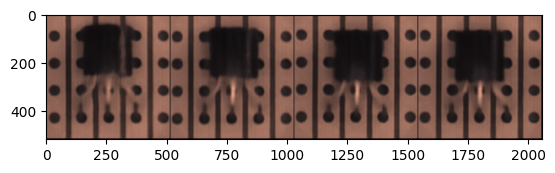


 EPOCH 13/50 	 train loss 0.0323423370718956 	 val loss 0.033489447087049484


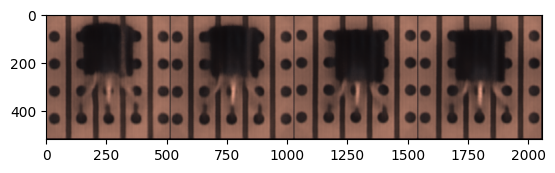


 EPOCH 14/50 	 train loss 0.03238276019692421 	 val loss 0.03353199362754822


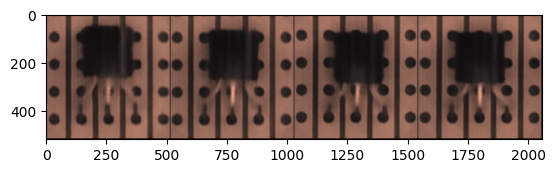


 EPOCH 15/50 	 train loss 0.031197821721434593 	 val loss 0.030973605811595917


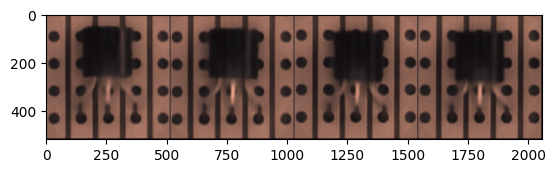

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 16/50 	 train loss 0.03030060976743698 	 val loss 0.03072962909936905


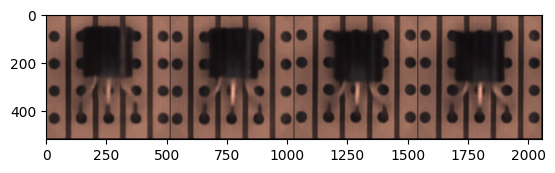

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 17/50 	 train loss 0.029969489201903343 	 val loss 0.03006194531917572


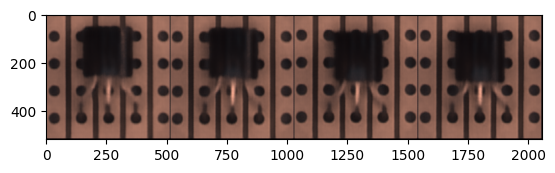

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 18/50 	 train loss 0.030635038390755653 	 val loss 0.03094588778913021


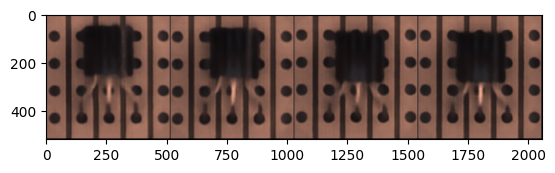

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 19/50 	 train loss 0.02954273670911789 	 val loss 0.031079798936843872


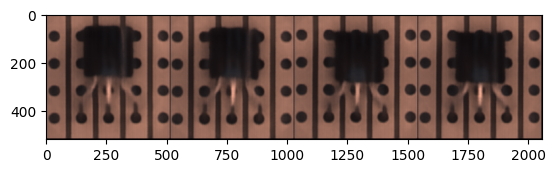

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 20/50 	 train loss 0.029074186459183693 	 val loss 0.0299515463411808


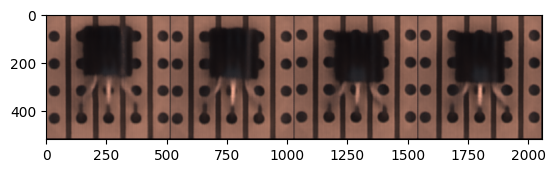

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 21/50 	 train loss 0.027647489681839943 	 val loss 0.029069963842630386


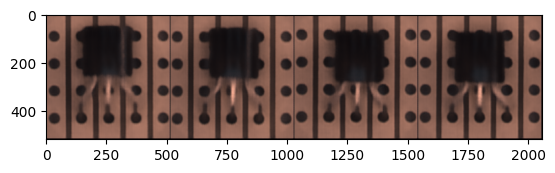


 EPOCH 22/50 	 train loss 0.027427859604358673 	 val loss 0.03035924769937992


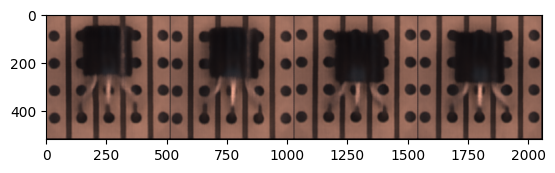

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 23/50 	 train loss 0.02733589895069599 	 val loss 0.03126620873808861


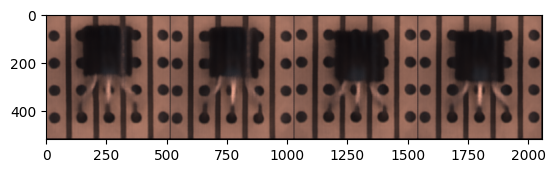

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 24/50 	 train loss 0.027596373111009598 	 val loss 0.031542710959911346


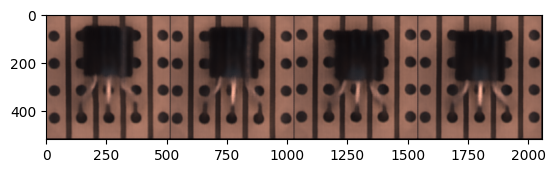

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 25/50 	 train loss 0.027597099542617798 	 val loss 0.02987642213702202


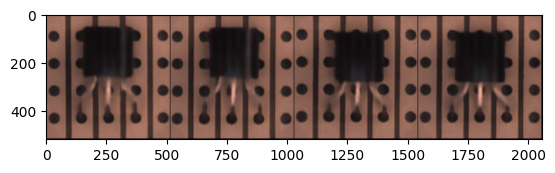

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 26/50 	 train loss 0.027359820902347565 	 val loss 0.029827408492565155


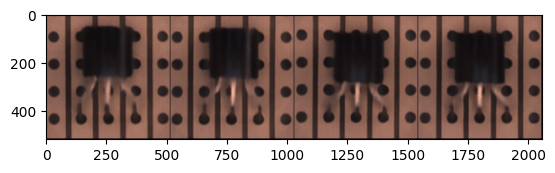

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 27/50 	 train loss 0.027387676760554314 	 val loss 0.02869008295238018


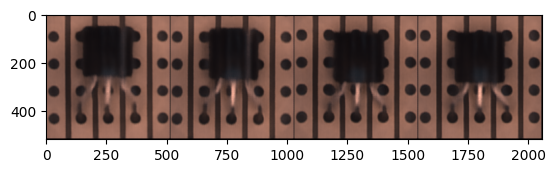

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 28/50 	 train loss 0.026545364409685135 	 val loss 0.02822922170162201


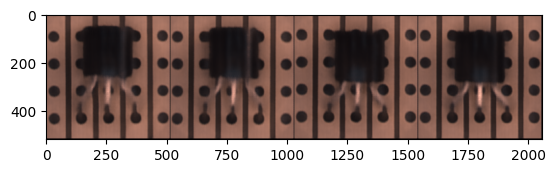

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 29/50 	 train loss 0.02651173621416092 	 val loss 0.0289759524166584


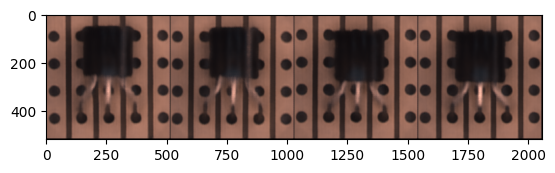

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 30/50 	 train loss 0.025336747989058495 	 val loss 0.02875535376369953


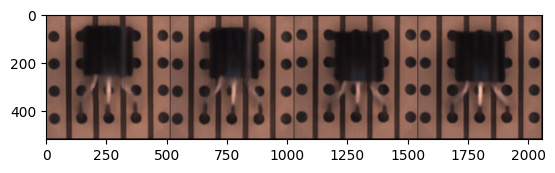

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 31/50 	 train loss 0.024997364729642868 	 val loss 0.027866197749972343


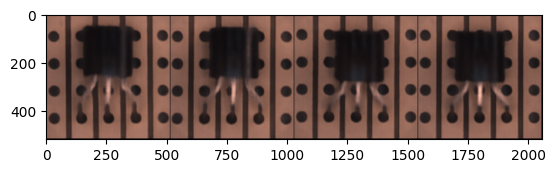

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 32/50 	 train loss 0.025594336912035942 	 val loss 0.0283114742487669


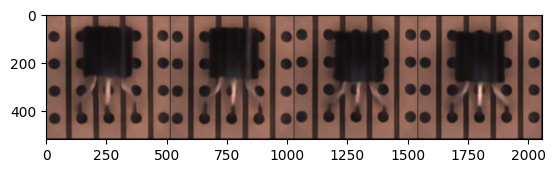

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 33/50 	 train loss 0.026062410324811935 	 val loss 0.027460189536213875


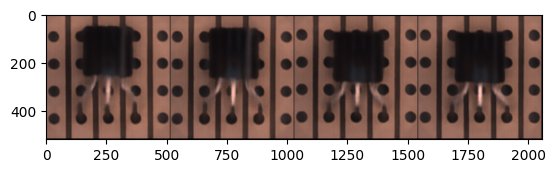

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 34/50 	 train loss 0.0253001619130373 	 val loss 0.029466435313224792


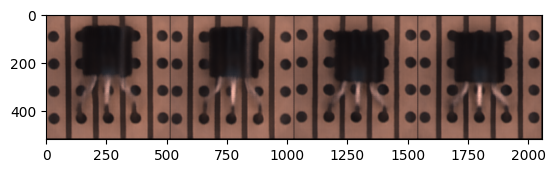

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 35/50 	 train loss 0.02581506222486496 	 val loss 0.02757881209254265


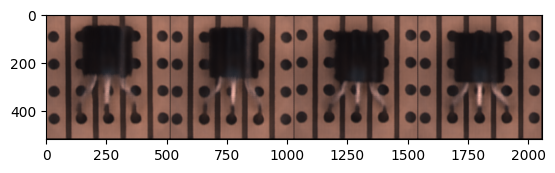

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 36/50 	 train loss 0.025712326169013977 	 val loss 0.028436072170734406


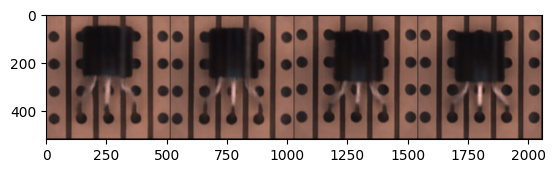

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 37/50 	 train loss 0.024709928780794144 	 val loss 0.027243906632065773


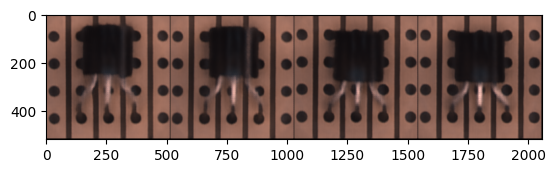

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 38/50 	 train loss 0.02409660629928112 	 val loss 0.02735019288957119


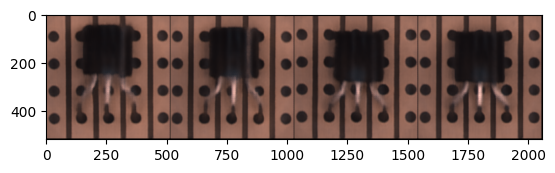

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 39/50 	 train loss 0.02426261454820633 	 val loss 0.02865244634449482


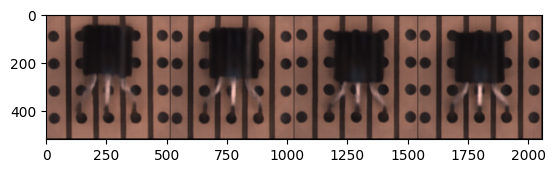

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 40/50 	 train loss 0.02407050132751465 	 val loss 0.02717369981110096


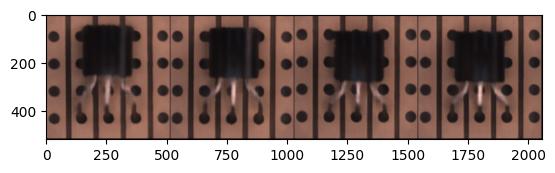

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 41/50 	 train loss 0.023911964148283005 	 val loss 0.027845926582813263


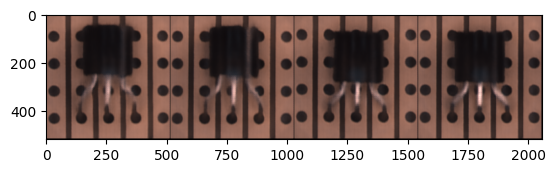

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 42/50 	 train loss 0.023592745885252953 	 val loss 0.028274433687329292


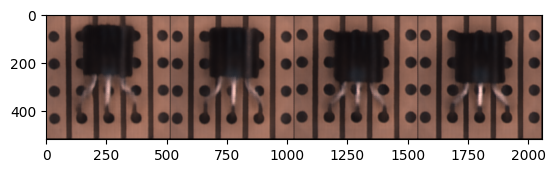

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 43/50 	 train loss 0.024751372635364532 	 val loss 0.031136529520154


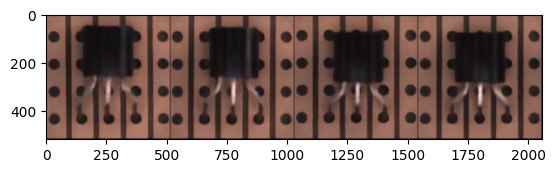

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 44/50 	 train loss 0.02559262327849865 	 val loss 0.027790671214461327


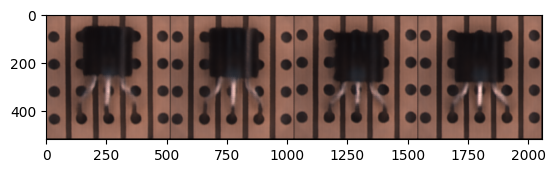

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 45/50 	 train loss 0.023843372240662575 	 val loss 0.027487725019454956


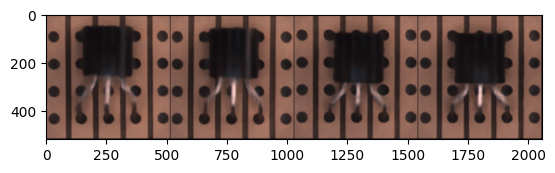

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 46/50 	 train loss 0.023853091523051262 	 val loss 0.028905127197504044


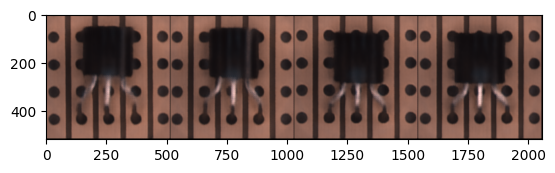

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 47/50 	 train loss 0.024477588012814522 	 val loss 0.030078139156103134


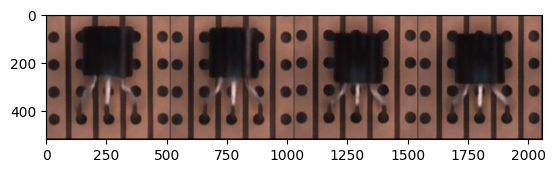

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 48/50 	 train loss 0.02448989637196064 	 val loss 0.02766193449497223


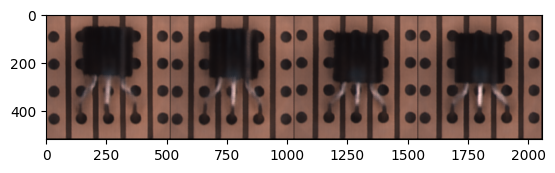

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 49/50 	 train loss 0.025599461048841476 	 val loss 0.02842688374221325


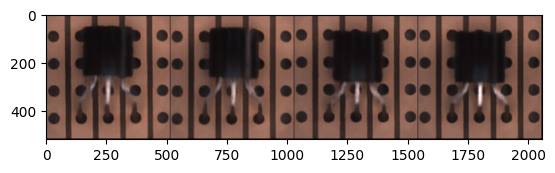

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 50/50 	 train loss 0.024937333539128304 	 val loss 0.028986405581235886


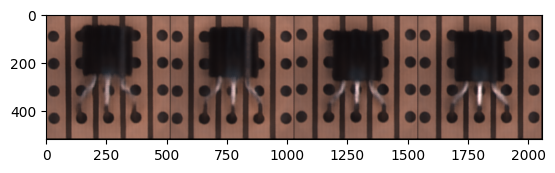

In [39]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim,scheduler)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

torch.Size([1, 3, 512, 512])
tensor([[[[0.1069, 0.4923, 0.5371,  ..., 0.4208, 0.4870, 0.3799],
          [0.4203, 0.5686, 0.5503,  ..., 0.6078, 0.4821, 0.4062],
          [0.5164, 0.5611, 0.5482,  ..., 0.5862, 0.5290, 0.5032],
          ...,
          [0.4244, 0.4924, 0.5860,  ..., 0.5437, 0.5901, 0.5258],
          [0.4351, 0.5254, 0.5137,  ..., 0.5062, 0.4879, 0.3638],
          [0.3383, 0.3875, 0.4336,  ..., 0.4532, 0.4011, 0.0903]],

         [[0.1418, 0.2845, 0.3839,  ..., 0.2515, 0.2809, 0.2610],
          [0.4039, 0.4355, 0.4465,  ..., 0.4047, 0.4105, 0.3010],
          [0.3469, 0.3739, 0.4280,  ..., 0.4489, 0.3606, 0.3659],
          ...,
          [0.2958, 0.4083, 0.3388,  ..., 0.4121, 0.3777, 0.3316],
          [0.3126, 0.3491, 0.3971,  ..., 0.3435, 0.4125, 0.2666],
          [0.2648, 0.2639, 0.2522,  ..., 0.2785, 0.2949, 0.2226]],

         [[0.0539, 0.0392, 0.2805,  ..., 0.0442, 0.2149, 0.1600],
          [0.3499, 0.3625, 0.3727,  ..., 0.3252, 0.3001, 0.2598],
          [0.

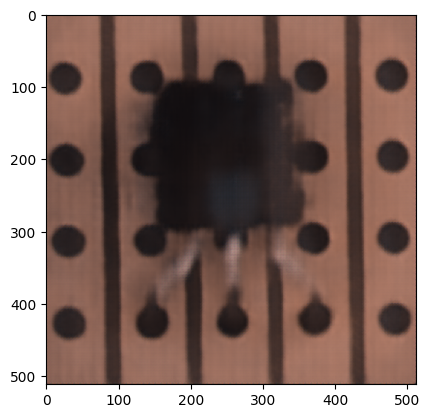

In [40]:
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
print(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Loss Plot

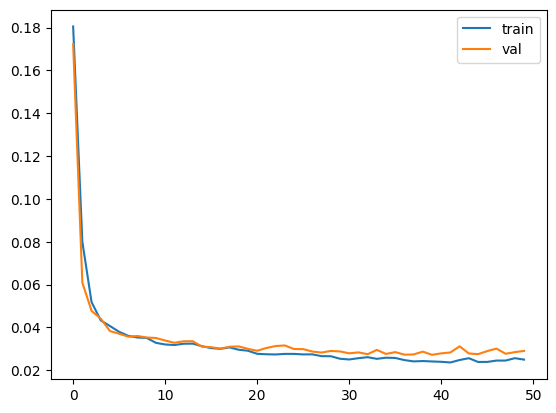

In [41]:
plt.plot(diz_loss['train_loss'],label='train')
plt.plot(diz_loss['val_loss'],label='val')
plt.legend()
plt.show()

Latent Representation

In [42]:
train = []
val = []
test = []
data = []
with torch.no_grad():
        for image_batch in train_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            train.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            val.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            test.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        train = torch.cat(train)
        val = torch.cat(val)
        test = torch.cat(test)
        data = torch.cat(data)


/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_4235/3762618135.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(train[:, 0], train[:, 1],cmap='hot',label='train')
/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_4235/3762618135.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot',label='val')
/var/folders/zq/n748bt1s4fdbgrfv7nj7s2n80000gn/T/ipykernel_4235/3762618135.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot',label='test')


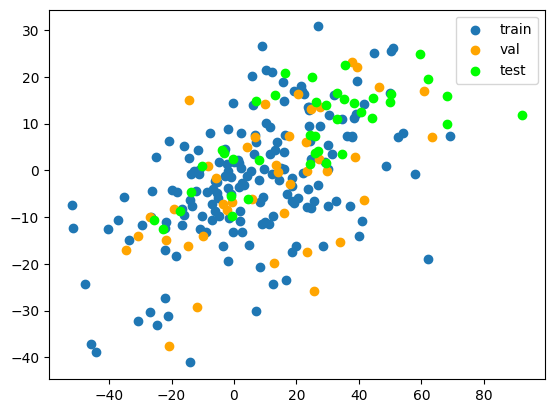

In [43]:

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(train[:, 0], train[:, 1],cmap='hot',label='train')
ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot',label='val')
ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot',label='test')

# ax = fig.add_subplot(projection='3d')
# ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot',label='train')
# ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot',label='val')
# ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot',label='test')

# Display the plot
plt.legend()
plt.show()

[1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0
 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1
 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0
 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0
 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0]
[[ 14.6743513   -0.75721708  -9.33292978  -2.51990798   8.20994229
   11.64305531  53.98615086  -6.21926985 -32.36230754   0.40481583
    6.67258601 -51.25790817  -8.60419629  15.66973387 -34.5322568
   -9.65266372]
 [  6.84815731  -0.49196897  -0.20251411   1.27697101  -0.66278061
  -24.3078148    9.70774628 -17.1547098   35.83224196  -0.72218954
   16.784978   -16.89650305  -5.2708637   12.86319232 -34.34671689
  -37.41308906]]


/Users/nayansavaliya/Desktop/AnomalyDetection/ad-venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


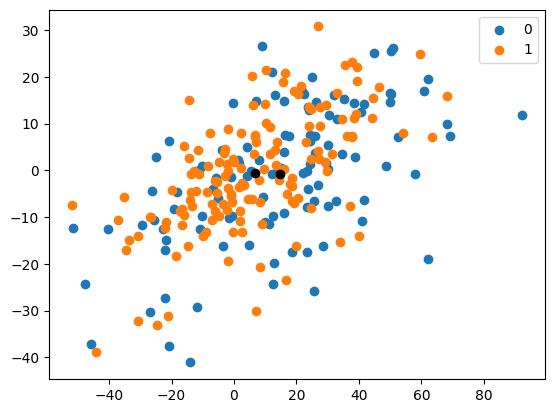

In [51]:
from sklearn import cluster
kmeans = cluster.KMeans(init='k-means++',n_clusters=2, random_state=0).fit(data)

labels = kmeans.labels_
print(labels)
centroids = kmeans.cluster_centers_
print(centroids)
u_labels = np.unique(labels)

fig = plt.figure()
ax = fig.add_subplot()
for i in u_labels:
    ax.scatter(data[labels == i , 0] , data[labels == i , 1] , label = i)

ax.scatter(centroids[:,0] , centroids[:,1] , color = 'k')
plt.legend()
plt.show()



In [53]:
# Kmeans prediction

kmeans.predict(test)

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [45]:
# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=2, random_state=0).fit(data)
# print(gm.means_)
# print(gm.predict(train))

Encoder-Decoder Output Loss Histogram

In [46]:
model.eval()
clean = []
defect = []

for image_batch in train_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    clean.append(mse.cpu().detach().item())

for image_batch in test_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    defect.append(mse.cpu().detach().item())





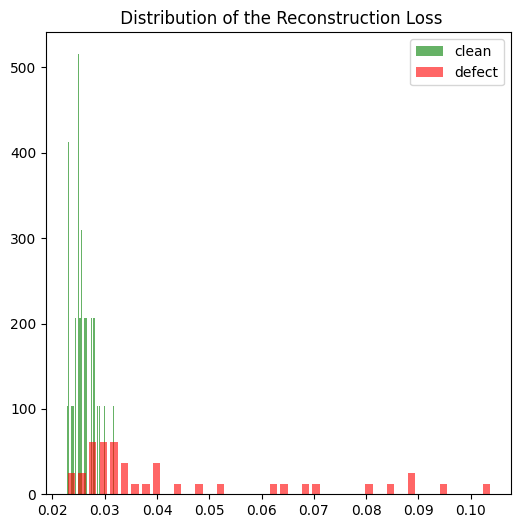

[0.023134738206863403, 0.027462352067232132, 0.024838527664542198, 0.02711043320596218, 0.024534523487091064, 0.02799377404153347, 0.02485039457678795, 0.024992063641548157, 0.028967034071683884, 0.029870709404349327, 0.027794767171144485, 0.025029554963111877, 0.02601693570613861, 0.026463624089956284, 0.025492345914244652, 0.025510847568511963, 0.025083985179662704, 0.02783551812171936, 0.025885870680212975, 0.027458466589450836, 0.024656986817717552, 0.02542218379676342, 0.02724701538681984, 0.022796591743826866, 0.02636760100722313, 0.02310921996831894, 0.02571764588356018, 0.024781841784715652, 0.02556268498301506, 0.025259708985686302, 0.02401125431060791, 0.023703116923570633, 0.031819768249988556, 0.02847519889473915, 0.02603719010949135, 0.02619272470474243, 0.028099019080400467, 0.02498200163245201, 0.02646513842046261, 0.023028118535876274, 0.024469783529639244, 0.02309292182326317, 0.02352147363126278] [0.051701705902814865, 0.02749553695321083, 0.033116452395915985, 0.0485

In [47]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=40, density=True, label="clean", alpha=.6, color="green", rwidth=0.7)
ax.hist(defect, bins=40, density=True, label="defect", alpha=.6, color="red", rwidth=0.7)

plt.title(" Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

print(clean, defect)